In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd '/content/drive/MyDrive/Project_682'

Mounted at /content/drive/
/content/drive/MyDrive/Project_682


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading and Cleaning Metadata

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
df.shape

(10015, 8)

In [ ]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dataset          object
dtype: object

In [ ]:
df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
count,10015,10015,10015,10015,9958.000000,10015,10015,10015
unique,7470,10015,7,4,NaN,3,15,4
top,HAM_0003789,ISIC_0029192,nv,histo,NaN,male,back,vidir_molemax
freq,6,1,6705,5340,NaN,5406,2192,3954
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64

In [ ]:
mean = int(df['age'].mean())
df['age'].fillna(mean,inplace=True)

In [ ]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

In [ ]:
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion_type'] = df['dx'].map(lesion_type.get) 
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes

In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
df['path'] = df['image_id'].map(imageid_path.get)

In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,lesion_type,lesion_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0032854.jpg


In [ ]:
df['lesion_type_idx'].value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: lesion_type_idx, dtype: int64

## Denoise, Resize and Data Augmentation

In [ ]:
import cv2
from cv2 import imread, resize

In [ ]:
def produce_new_img(img2):
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

X = []
y = []

kernel = cv2.getStructuringElement(1,(17,17)) # Kernel for the morphological filtering

for i in range(len(df)):
  src = cv2.imread(df['path'][i])
  grayScale = cv2.cvtColor( src, cv2.COLOR_RGB2GRAY ) #1 Convert the original image to grayscale
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) #2 Perform the blackHat filtering on the grayscale image to find the hair countours
  ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY) # intensify the hair countours in preparation for the inpainting algorithm
  dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA) # inpaint the original image depending on the mask

  file_to_read = df['path'][i]
  img = imread(file_to_read)
  img2 = resize(dst,(64,64))
  X.append(img2)
    
  #targets
  output = df['lesion_type_idx'][i]
  y.append(output)
    
  # add more images for class between 1-6, rotating them 
  if output != 4:
    new_img = produce_new_img(img2)
    for i in range(5):
      X.append(new_img[i])
      y.append(output)

In [ ]:
print(y.count(0),y.count(1),y.count(2),y.count(3),y.count(4),y.count(5),y.count(6))

1962 3084 6594 690 6705 6678 852


## Saving data after pre-processing

In [ ]:
import pickle

In [ ]:
file_name = "X.pkl"

#open_file = open(file_name, "wb")
#pickle.dump(X, open_file)
#open_file.close()

open_file = open(file_name, "rb")
X = pickle.load(open_file)
open_file.close()

#print(X)

In [ ]:
X= np.array(X)

In [ ]:
X.shape

In [ ]:
X = X.astype(np.float64)

In [ ]:
X.dtype

In [ ]:
file_name = "y.pkl"

#open_file = open(file_name, "wb")
#pickle.dump(y, open_file)
#open_file.close()

open_file = open(file_name, "rb")
y = pickle.load(open_file)
open_file.close()

#print(y)

In [ ]:
y = np.array(y)

In [ ]:
y.shape

In [ ]:
from keras.utils.np_utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

In [ ]:
X = X.astype(np.float64)

In [ ]:
#y_train = [1 if each == 5 else 0 for each in y]

## Train and Test split

In [ ]:
from sklearn.model_selection import train_test_split

# split in 70% training and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.20, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (21252, 64, 64, 3)
Test dataset shape (5313, 64, 64, 3)


## ResNet-152

In [ ]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models.
print_every = 100
print('Using device: ', device)

Using device:  /device:GPU:0


In [ ]:
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df['lesion_type_idx'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 1.93, 1: 1.23, 2: 0.58, 3: 5.5, 4: 0.57, 5: 0.57, 6: 4.45}


In [ ]:
# building Neural Network

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
#pre_trained_model = tf.keras.applications.MobileNet(include_top=False,
#                                                    input_shape=(SIZE, SIZE, 3),
#                                                    weights='imagenet')
#resnet152 - 564 layers
pre_trained_model = tf.keras.applications.ResNet152V2(include_top=False,
                             input_shape=(64, 64, 3),
                             weights='imagenet')


#for layer in pre_trained_model.layers[:48]:
#    layer.trainable = False
#for layer in pre_trained_model.layers[48:]:
#    layer.trainable = True

for layer in pre_trained_model.layers[:1]:
    layer.trainable = False
for layer in pre_trained_model.layers[1:]:
    layer.trainable = True


model = tf.keras.models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(7, activation='softmax')
])

#print(str(len(pre_trained_model.layers)))

In [ ]:
# training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# max 10 iterations without improvements
early_stopping = EarlyStopping(monitor='val_accuracy',
                               mode='max',
                               patience=10)

#saving best model
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [early_stopping, checkpoint]

batch_size = 32
epochs = 30
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(X_train)

history=model.fit(datagen.flow(X_train,y_train), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callback_list, validation_data=(X_test, y_test), class_weight=class_weights)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
665/665 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.4695
Epoch 00001: val_accuracy improved from -inf to 0.61190, saving model to modelv2_2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


665/665 [==============================] - 123s 162ms/step - loss: 1.3075 - accuracy: 0.4695 - val_loss: 0.9990 - val_accuracy: 0.6119
Epoch 2/30
665/665 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.6325
Epoch 00002: val_accuracy improved from 0.61190 to 0.68154, saving model to modelv2_2.h5
665/665 [==============================] - 119s 180ms/step - loss: 0.8218 - accuracy: 0.6325 - val_loss: 0.8400 - val_accuracy: 0.6815
Epoch 3/30
665/665 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.6937
Epoch 00003: val_accuracy improved from 0.68154 to 0.70676, saving model to modelv2_2.h5
665/665 [==============================] - 119s 178ms/step - loss: 0.6508 - accuracy: 0.6937 - val_loss: 0.7824 - val_accuracy: 0.7068
Epoch 4/30
665/665 [==============================] - ETA: 0s - loss: 0.5548 - accuracy: 0.7330
Epoch 00004: val_accuracy improved from 0.70676 to 0.73687, saving model to modelv2_2.h5
665/665 [==============================]

In [ ]:
#getting the iteration results
history_df = pd.DataFrame(history.history)
history_df.to_csv('resnetV152_hyper.csv')

In [ ]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.307504,0.469509,0.999048,0.611895
1,0.821762,0.632458,0.840048,0.681536
2,0.650813,0.693676,0.782364,0.706757
3,0.554826,0.733013,0.682473,0.736872
4,0.473731,0.770139,0.561360,0.789008
5,0.400069,0.802983,0.783966,0.708639
6,0.349781,0.824064,0.724118,0.740072
7,0.318666,0.844156,0.601026,0.788067
8,0.288390,0.857002,0.944396,0.696970
9,0.243456,0.881046,1.485562,0.579522


In [ ]:
# getting the best model
model = load_model('model.h5')
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

167/167 [==============================] - 9s 42ms/step - loss: 0.2873 - accuracy: 0.9177
Accuracy: 91.77%


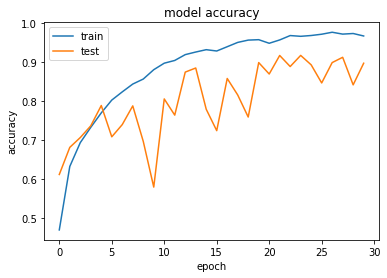

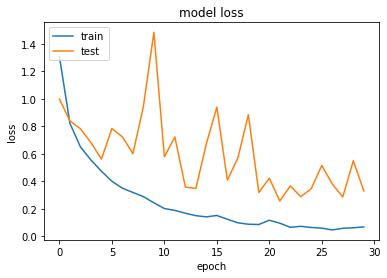

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 5313 	accurately-predicted-data: 4876 	 wrongly-predicted-data:  437
Accuracy: 91.775 %


In [ ]:
best_model = load_model('model.h5')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

In [ ]:
file_name = "ResNet.pkl"

open_file = open(file_name, "wb")
pickle.dump(best_model, open_file)
open_file.close()

In [ ]:
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

In [ ]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.95
accuracy for Melanoma = 0.92
accuracy for Benign keratosis-like lesions  = 0.95
accuracy for Basal cell carcinoma = 0.97
accuracy for Actinic keratoses = 0.83
accuracy for Vascular lesions = 0.94
accuracy for Dermatofibroma = 0.99


In [ ]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.9161603613777526

In [ ]:
from sklearn.metrics import confusion_matrix
train_pred = best_model.predict(X_train)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = best_model.predict(X_test)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(y_test, test_pred_classes)
confusionmatrix

array([[ 407,    4,   14,    0,    1,    2,    0],
       [  15,  608,   16,   11,    2,    8,    1],
       [   6,    5, 1220,    1,   14,   38,    0],
       [   2,    0,    2,  132,    0,    0,    0],
       [   6,   16,   91,    3, 1085,   99,    4],
       [   4,    2,   24,    0,   44, 1250,    0],
       [   0,    0,    0,    0,    1,    1,  174]])

In [ ]:
from sklearn.metrics import confusion_matrix
train_pred = best_model.predict(X_train)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = best_model.predict(X_test)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(y_test, test_pred_classes)
confusionmatrix

array([[ 407,    4,   14,    0,    1,    2,    0],
       [  15,  608,   16,   11,    2,    8,    1],
       [   6,    5, 1220,    1,   14,   38,    0],
       [   2,    0,    2,  132,    0,    0,    0],
       [   6,   16,   91,    3, 1085,   99,    4],
       [   4,    2,   24,    0,   44, 1250,    0],
       [   0,    0,    0,    0,    1,    1,  174]])

In [ ]:
classes=[0,1,2,3,4,5,6]

In [ ]:
con_mat_norm = np.around(confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

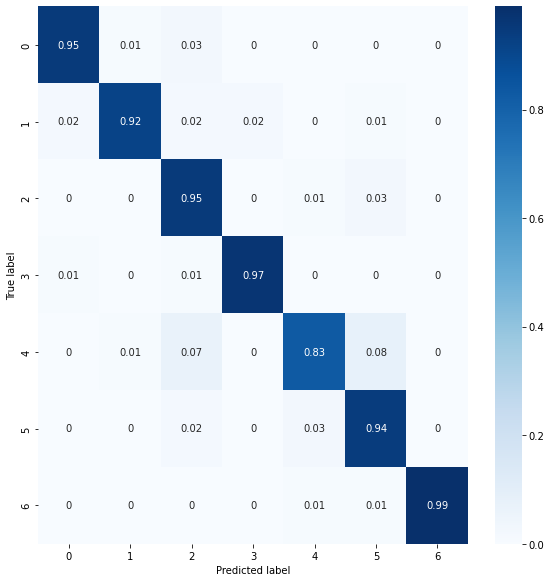

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()